In [31]:
%load_ext disable_autoscroll

%pylab inline
pylab.rcParams['figure.figsize'] = (13, 10)

import pandas as pd
import seaborn as sns
import scipy as sp
import scipy.stats as stats
from pandas.tools.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler

The disable_autoscroll extension is already loaded. To reload it, use:
  %reload_ext disable_autoscroll
Populating the interactive namespace from numpy and matplotlib


In [2]:
scores = pd.read_csv("../data/ES_2-5_79cases_newVnames.csv")
scores.head();

In [13]:
labels = pd.read_csv("../data/transcripts/dialogues/prepLIWC_allFiles.trigrams.ctxc0-1.cnt2.seq.label.withnames", sep="\t", names=["meta", "label"])
labels.head();

In [14]:
labels['filename'] = labels['meta'].apply(lambda x: x.split(".")[0])
labels['lineno'] = labels['meta'].apply(lambda x: x.split(".")[1])
labels['speaker'] = labels['meta'].apply(lambda x: x.split(".")[2].strip())
labels.head();

In [15]:
# Var for therapists
therapist = ['Interviewer', 'Therapist']
labels['therapist'] = False
labels.ix[labels['speaker'].isin(therapist),'therapist'] = True
labels.head();

In [16]:
labels['FAMILY'] = labels['filename'].apply(lambda x: x.split()[0].split("-")[0].split("_")[0].replace("A2FB", ""))
labels.head();

In [17]:
# Agg into counts of label
tmp = labels.groupby(['FAMILY', 'therapist', 'label']).agg(len)
tmp.reset_index(inplace = True)
tmp = tmp.rename(columns={'meta':'frequency'})
tmp = tmp.drop(['filename', 'lineno', 'speaker'], axis = 1)
tmp.head();

In [18]:
data = pd.merge(tmp, scores[['FAMILY', 'Hop2', 'FB2']], left_on = "FAMILY", right_on = 'FAMILY')
data.head()

,FAMILY,therapist,label,frequency,Hop2,FB2
0,ESC413,False,Agreement,2,6,5.8
1,ESC413,False,Backchannel,22,6,5.8
2,ESC413,False,Other,43,6,5.8
3,ESC413,False,Question,1,6,5.8
4,ESC413,False,Statement,56,6,5.8


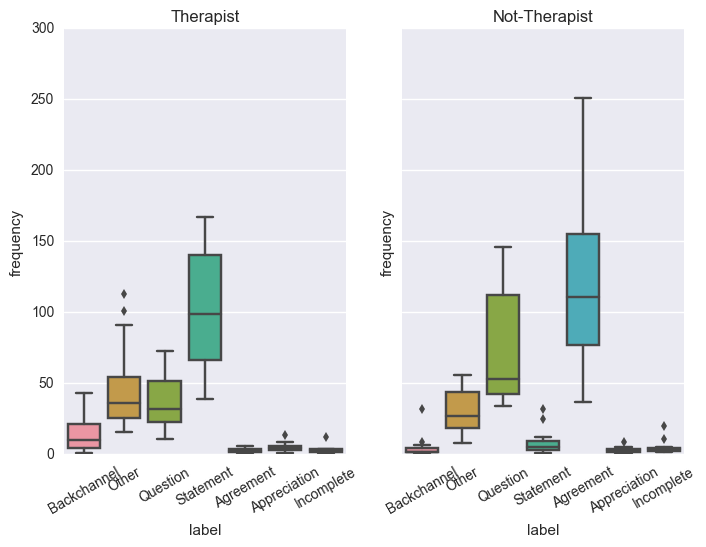

In [19]:
fig, axs = plt.subplots(ncols = 2, sharey = True)
g = sns.boxplot(x = 'label',
            y = 'frequency', data = data[data['therapist'] == True],
            ax = axs[0]);
axs[0].set_title("Therapist")
g = sns.boxplot(x = 'label',
            y = 'frequency',
            data = data[data['therapist'] == False],
            ax = axs[1]);
axs[1].set_title("Not-Therapist")
#plt.ylabel("Freq. of label");
#plt.title("Label frequency for therapist dialogue")

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)

plt.show();

Calculate the spearman correlation between the frequency of each label and the Hop2 score. TODO: Use p-value correction.

### Therapist correlations
#### Hop2

In [ ]:
for label in data.label.unique():
    therapist_d = data[data.therapist == True]
    therapist_d = therapist_d[therapist_d.label == label]

    # Spearman's correlation w/ score
    print(label)
    print(stats.spearmanr(therapist_d['frequency'], therapist_d['Hop2']))
    print()


#### FB2

In [ ]:
for label in data.label.unique():
    therapist_d = data[data.therapist == True]
    therapist_d = therapist_d[therapist_d.label == label]

    # Spearman's correlation w/ score
    print(label)
    print(stats.spearmanr(therapist_d['frequency'], therapist_d['FB2']))
    print()

### Non-therapist correlations
#### Hop2

In [ ]:
for label in data.label.unique():
    therapist_d = data[data.therapist == False]
    therapist_d = therapist_d[therapist_d.label == label]

    # Spearman's correlation w/ score
    print(label)
    print(stats.spearmanr(therapist_d['frequency'], therapist_d['Hop2']))
    print()


#### FB2

In [ ]:
for label in data.label.unique():
    therapist_d = data[data.therapist == False]
    therapist_d = therapist_d[therapist_d.label == label]

    # Spearman's correlation w/ score
    print(label)
    print(stats.spearmanr(therapist_d['frequency'], therapist_d['FB2']))
    print()


## Other visualizations
First, we construct a new dataset with labels as columns. We scale this data to be 0 - 1 for the parallel coordinates plot. Since the pivoting procedure drops the scores, we re-merge them just like before.

In [40]:
pivoted_data = pd.pivot_table(data, values = 'frequency', index = ['FAMILY', 'therapist'], columns = 'label')
pivoted_data.reset_index(inplace = True)
pivoted_data = pivoted_data.fillna("0.0")

sel_columns = ['Agreement', 'Appreciation', 'Backchannel', 'Incomplete', 'Other', 'Question', 'Statement']

#Convert columns to numeric
pivoted_data[sel_columns] = pivoted_data[sel_columns].apply(pd.to_numeric)

#Scale to 0 - 1
scaler = MinMaxScaler()
pivoted_data[sel_columns] = scaler.fit_transform(pivoted_data[sel_columns])

pivoted_data.head();

In [41]:
pivoted_data = pd.merge(pivoted_data, scores[['FAMILY', 'Hop2', 'FB2']], on = 'FAMILY')
pivoted_data.head();

In [42]:
pivoted_data['Hop2_HIGH'] = pivoted_data['Hop2'] > sp.median(pivoted_data['Hop2'])

In [43]:
pivoted_therapist = pivoted_data[pivoted_data['therapist'] == True].drop('therapist', axis = 1)
pivoted_other = pivoted_data[pivoted_data['therapist'] == False].drop('therapist', axis = 1)

### Parallel coordinates (aka The Jackson Pollock plot)

In [30]:
parallel_coordinates??

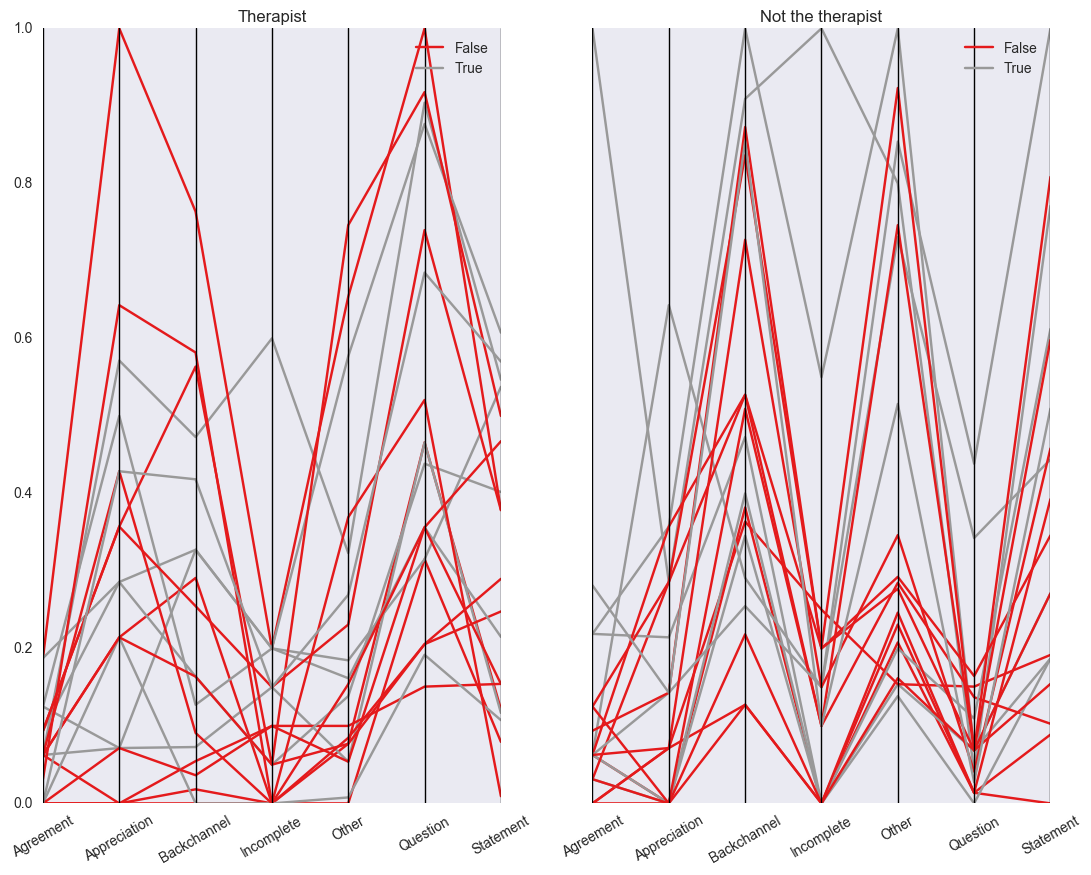

In [39]:
fig, axs = plt.subplots(ncols = 2, sharey = True)
parallel_coordinates(pivoted_therapist.drop(['Hop2', 'FB2', 'FAMILY'], axis = 1), 'Hop2_HIGH', colormap = "Set1", ax=axs[0]);
axs[0].set_title("Therapist");

parallel_coordinates(pivoted_other.drop(['Hop2', 'FB2', 'FAMILY'], axis = 1), 'Hop2_HIGH', colormap = "Set1", ax=axs[1]);
axs[1].set_title("Not the therapist");

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)


plt.show();

### Paired plot

In [ ]:
sns.pairplot(pivoted_therapist, hue = 'FAMILY')

In [ ]:
sns.pairplot(pivoted_therapist, hue = 'FAMILY', vars = ['Agreement', 'Backchannel', 'Question'])

### Linear relationship plot
The following figures plot the linear relationship between number of X and the Hop2 rating, where X is one of the labels given by the language model. Therapist and not-Therapist dialogue is split into columns. Each plot also shows the 95% confidence interval for the regression estimate (i.e., translucent bands around the regression line). The confidence interval is estimated using a bootstrap procedure.

In [ ]:
for col in sel_columns:
    sns.lmplot(x = col, y = "Hop2", hue = "therapist", col = "therapist", data = pivoted_data, markers=["o", "x"], palette="Set1");